In [12]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import folium
import math
import warnings
import pyproj


from shapely.prepared import prep
from shapely.geometry import Point,Polygon
from shapely.ops import transform,cascaded_union
from functools import partial
from geopy import distance
from scipy import spatial


warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

In [2]:
district_shp_path  = '../data/vector/pak_administrative_shapefiles/District_Boundary.shp'

In [3]:
def func_voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def func_intersect_vor(row):
    return bbox.intersection(row.vor)

def func_point_from_latlon(row):
    return geometry.Point(row.lat,row.lon)

def func_flip(x, y):
    """Flips the x and y coordinate values"""
    return y, x

def func_latlon_from_lat_lon(row):
    return (row.lat,row.lon)

    
def func_get_area(row):
    geom = row.bounded_vor
    geom_area = transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat_1=geom.bounds[1],
            lat_2=geom.bounds[3]
        )
    ),
    geom)
    return geom_area.area

def func_get_distrcit_grid(district_name,resolution):

    shp = districts_gpd[districts_gpd.DISTRICT==district_name]
    shp = shp.to_crs(epsg=3857)
    poly = shp.geometry.values[0]

    latmin, lonmin, latmax, lonmax = poly.bounds

    # construct a rectangular mesh

    prep_polygon = prep(poly)
    valid_points = []
    points = []

    #0.012 degrees is approximately equal to 1km
    # resolution = 1000

    for lat in np.arange(latmin, latmax, resolution):
        for lon in np.arange(lonmin, lonmax, resolution):
            points.append(Point((round(lat,4), round(lon,4))))

    # validate if each point falls inside shape using
    # the prepared polygon
    valid_points.extend(filter(prep_polygon.contains, points))


    mesh =  gpd.GeoDataFrame(valid_points)
    mesh = mesh.reset_index()
    mesh = mesh.rename(columns={
        'index':'p_id',
        0:'geometry'
        })

    mesh['p_id'] = mesh.p_id.apply(lambda x: 'p{id}'.format(id=str(x)))

    mesh['geometry'] = mesh['geometry'].apply(lambda x: transform(func_flip,x))
    mesh['geometry'] = mesh['geometry'].apply(lambda x: transform(func_flip,x))

    mesh.crs = 'EPSG:3857'
    mesh = mesh.to_crs(crs=4326)
    
    return mesh
    

## testing for one locaiton, Karachi SOUTH

In [6]:
districts_gpd = gpd.read_file(district_shp_path)
ke_shp = districts_gpd[districts_gpd.DISTRICT=='KARACHI SOUTH']
ke_shp = ke_shp.to_crs(epsg=3857)
poly = ke_shp.geometry.values[0]

latmin, lonmin, latmax, lonmax = poly.bounds

# construct a rectangular mesh

prep_polygon = prep(poly)
valid_points = []
points = []

#0.012 degrees is approximately equal to 1km
resolution = 1000

for lat in np.arange(latmin, latmax, resolution):
    for lon in np.arange(lonmin, lonmax, resolution):
        points.append(Point((round(lat,4), round(lon,4))))

# validate if each point falls inside shape using
# the prepared polygon
valid_points.extend(filter(prep_polygon.contains, points))


mesh =  gpd.GeoDataFrame(valid_points)
mesh = mesh.reset_index()
mesh = mesh.rename(columns={
    'index':'p_id',
    0:'geometry'
    })

mesh['p_id'] = mesh.p_id.apply(lambda x: 'p{id}'.format(id=str(x)))

mesh['geometry'] = mesh['geometry'].apply(lambda x: transform(func_flip,x))
mesh['geometry'] = mesh['geometry'].apply(lambda x: transform(func_flip,x))

mesh.crs = 'EPSG:3857'
mesh = mesh.to_crs(crs=4326)

In [7]:
loc = list(mesh.geometry[0].coords)[0]
loc = loc[::-1]
map_ = folium.Map(location=loc)

map_.add_child(folium.GeoJson(data=mesh,popup=mesh.p_id,tooltip=mesh.p_id))
map_.add_child(folium.GeoJson(data=ke_shp))

In [71]:
map_.save('../viz/karachi_south_grid.html')

## make function

In [8]:
districts_gpd = gpd.read_file(district_shp_path)

In [11]:
mesh = func_get_distrcit_grid('LAHORE',1000)

In [6]:
shp = districts_gpd[districts_gpd.DISTRICT=='KARACHI CENTRAL'].geometry.values[0]

In [7]:
loc = list(mesh.geometry[0].coords)[0]
loc = loc[::-1]
map_ = folium.Map(location=loc)

map_.add_child(folium.GeoJson(data=mesh,popup=mesh.p_id,tooltip=mesh.p_id))
map_.add_child(folium.GeoJson(data=shp))

In [66]:
map_.save('../viz/karachi_central_grid.html')

In [77]:
lhr_mesh = func_get_distrcit_grid(district_name='LAHORE',resolution=1000)

In [81]:
mesh = lhr_mesh

In [82]:
shp = districts_gpd[districts_gpd.DISTRICT=='LAHORE'].geometry.values[0]

In [83]:
loc = list(mesh.geometry[0].coords)[0]
loc = loc[::-1]
map_ = folium.Map(location=loc)

map_.add_child(folium.GeoJson(data=mesh,popup=mesh.p_id,tooltip=mesh.p_id))
map_.add_child(folium.GeoJson(data=shp))

In [87]:
mesh['coords']=mesh.geometry.apply(lambda x: list(x.coords)[0])

In [89]:
mesh['lon'],mesh['lat']=mesh.coords.apply(lambda x: x[0]),mesh.coords.apply(lambda x: x[1])

In [93]:
mesh = mesh.drop(columns=['coords'])

In [94]:
mesh.to_file('../data/vector/dev/LAHORE/lahore_mesh.shp')

## making a fishnet-ish grid

In [9]:
mesh = gpd.read_file('../data/vector/dev/LAHORE/lahore_mesh.shp')

In [19]:
bbox = districts_gpd[districts_gpd.DISTRICT=='LAHORE']['geometry'].values[0]
bbox  = [coord[::-1] for coord in bbox.exterior.coords]
bbox = Polygon(bbox)

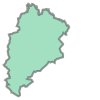

In [121]:
bbox

In [18]:
mesh['lat_lon'] =  mesh.apply(func_latlon_from_lat_lon,1)

In [21]:
vor = spatial.Voronoi(list(mesh['lat_lon'].values))

In [22]:
regions,vertices=func_voronoi_finite_polygons_2d(vor,radius=0.07)

In [23]:
polys = []
for region in regions:
    poly = vertices[region]
    polys.append(Polygon(poly))

vor_gpd = gpd.GeoDataFrame(polys)
vor_gpd = vor_gpd.rename(columns={
    0:'vor'
})
vor_gpd['bounded_vor'] = vor_gpd.apply(func_intersect_vor,1)
vor_gpd = gpd.GeoDataFrame(vor_gpd,geometry='bounded_vor')
vor_gpd = vor_gpd.drop(columns='vor')
vor_gpd = vor_gpd.reset_index()
vor_gpd = vor_gpd.rename(columns={'index':'vor_id'})
vor_gpd['vor_id'] = vor_gpd.vor_id.apply(lambda x: 'vor'+str(x))

In [34]:
lon,lat = list(polys[0].exterior.coords)[0][0],list(polys[0].exterior.coords)[0][1]

In [36]:
lat

-141.85914043978886

In [37]:
map_  = folium.Map(location=(31.4769257,74.2725534),
                   zoom_start=12)

for ind,row in vor_gpd.iterrows():
    try:
        polygon = folium.Polygon(row.bounded_vor.exterior.coords)
    except AttributeError:
        pass
    map_.add_child(polygon)
map_

In [38]:
map_.save('../viz/lahore_voroni_fishnet.html')

In [31]:
vor_gpd.to_file('../data/vector/dev/LAHORE/lahore_voronoi_fishnet.shp')

/home/hishamsajid113/anaconda3/envs/fnfjug/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [51]:
vor_gpd.bounded_vor[433].area*6370**2

2791.6937863425987

In [84]:
vor_gpd['area'] = vor_gpd.apply(func_get_area,1)

In [98]:
vor_gpd['area_sqrt'] = vor_gpd['area'].apply(lambda x: math.sqrt(x))

<AxesSubplot:ylabel='Frequency'>

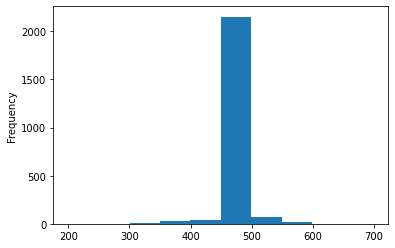

In [107]:
vor_gpd.area_sqrt.plot(kind='hist')

### creating a 2000x2000 mesh for bigger grid since 1000x1000 leads to ~500 m polygons

In [14]:
lhr_mesh = func_get_distrcit_grid(district_name='LAHORE',resolution=2000)

In [15]:
lhr_mesh['coords'] = lhr_mesh.geometry.apply(lambda x: list(x.coords)[0][::-1])

In [16]:
vor = spatial.Voronoi(list(lhr_mesh['coords'].values))

In [17]:
regions,vertices=func_voronoi_finite_polygons_2d(vor,radius=0.07)

In [20]:
polys = []
for region in regions:
    poly = vertices[region]
    polys.append(Polygon(poly))

vor_gpd = gpd.GeoDataFrame(polys)
vor_gpd = vor_gpd.rename(columns={
    0:'vor'
})
vor_gpd['bounded_vor'] = vor_gpd.apply(func_intersect_vor,1)
vor_gpd = gpd.GeoDataFrame(vor_gpd,geometry='bounded_vor')
vor_gpd = vor_gpd.drop(columns='vor')
vor_gpd = vor_gpd.reset_index()
vor_gpd = vor_gpd.rename(columns={'index':'vor_id'})
vor_gpd['vor_id'] = vor_gpd.vor_id.apply(lambda x: 'vor'+str(x))

In [21]:
map_  = folium.Map(location=(31.4769257,74.2725534),
                   zoom_start=12)

for ind,row in vor_gpd.iterrows():
    try:
        polygon = folium.Polygon(row.bounded_vor.exterior.coords)
    except AttributeError:
        pass
    map_.add_child(polygon)
map_

In [129]:
vor_gpd['area_sq'] = vor_gpd.apply(func_get_area,1)

In [130]:
vor_gpd['area_sqrt'] = vor_gpd.area_sq.apply(lambda x: math.sqrt(x))

<AxesSubplot:ylabel='Frequency'>

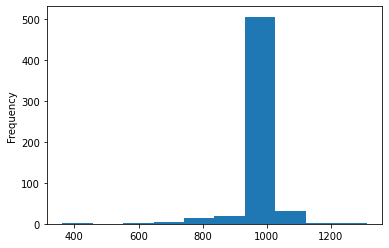

In [132]:
vor_gpd.area_sqrt.plot(kind='hist')

In [134]:
vor_gpd.area_sqrt.mean()

960.7274894348404

In [135]:
vor_gpd.to_file('../data/vector/dev/LAHORE/lahore_voronoi_fishnet_1000m.shp')

## ISLAMABAD 

In [30]:
isb_mesh  = func_get_distrcit_grid('ISLAMABAD',2000)

In [31]:
isb_mesh['coords'] = isb_mesh.geometry.apply(lambda x: list(x.coords)[0][::-1])

In [32]:
vor = spatial.Voronoi(list(isb_mesh['coords'].values))

In [33]:
regions,vertices=func_voronoi_finite_polygons_2d(vor,radius=0.07)

In [34]:
bbox = districts_gpd[districts_gpd.DISTRICT=='ISLAMABAD']['geometry'].values[0]
bbox  = [coord[::-1] for coord in bbox.exterior.coords]
bbox = Polygon(bbox)

In [35]:
polys = []
for region in regions:
    poly = vertices[region]
    polys.append(Polygon(poly))

vor_gpd = gpd.GeoDataFrame(polys)
vor_gpd = vor_gpd.rename(columns={
    0:'vor'
})
vor_gpd['bounded_vor'] = vor_gpd.apply(func_intersect_vor,1)
vor_gpd = gpd.GeoDataFrame(vor_gpd,geometry='bounded_vor')
vor_gpd = vor_gpd.drop(columns='vor')
vor_gpd = vor_gpd.reset_index()
vor_gpd = vor_gpd.rename(columns={'index':'vor_id'})
vor_gpd['vor_id'] = vor_gpd.vor_id.apply(lambda x: 'vor'+str(x))

In [36]:
vor_gpd

vor_id                                        bounded_vor
0      vor0  POLYGON ((33.68857 72.82969, 33.68304 72.83472...
1      vor1  POLYGON ((33.70352 72.83449, 33.70348 72.83445...
2      vor2  POLYGON ((33.71740 72.85181, 33.71641 72.84984...
3      vor3  POLYGON ((33.65867 72.85503, 33.65682 72.85618...
4      vor4  POLYGON ((33.66873 72.84773, 33.66836 72.84806...
..      ...                                                ...
323  vor323  POLYGON ((33.63706 73.34244, 33.63979 73.34361...
324  vor324  POLYGON ((33.67362 73.35487, 33.67362 73.33690...
325  vor325  POLYGON ((33.68239 73.35487, 33.68354 73.34587...
326  vor326  POLYGON ((33.65691 73.35633, 33.65737 73.35704...
327  vor327  POLYGON ((33.67362 73.36993, 33.67731 73.37277...

[328 rows x 2 columns]

In [37]:
map_  = folium.Map(location=(31.4769257,74.2725534),
                   zoom_start=12)

for ind,row in vor_gpd.iterrows():
    try:
        polygon = folium.Polygon(row.bounded_vor.exterior.coords)
    except AttributeError:
        pass
    map_.add_child(polygon)
map_

In [47]:
vor_gpd['area_sq'] = vor_gpd.apply(func_get_area,1)

In [48]:
vor_gpd['area_sqrt'] = vor_gpd.area_sq.apply(lambda x: math.sqrt(x))

In [50]:
vor_gpd.to_file('../data/vector/dev/ISLAMABAD/islamabad_voronoi_fishnet.shp')

## KARACHI

In [52]:
# will need to merge all karachi districts into one
districts_gpd = gpd.read_file(district_shp_path)
karachi_districts = districts_gpd[districts_gpd.DISTRICT.isin(['KARACHI CENTRAL', 'KARACHI WEST',
       'MALIR CANTONMENT', 'KORANGI CREEK CANTONMENT',
       'MANORA CANTONMENT', 'CLIFTON CANTONMENT', 'KARACHI CANTONMENT',
       'FAISAL CANTONMENT', 'KARACHI SOUTH', 'MALIR', 'KORANGI',
       'KARACHI EAST'])]
karachi_whole_poly = cascaded_union(karachi_districts.geometry)
karachi_whole_df = pd.DataFrame(np.array([[130,'SINDH','KARACHI FULL',0,'CUSTOM',karachi_districts.Shape_Le_1.sum(),
                                          karachi_districts.Shape_Le_2.sum(),karachi_districts.Shape_Area.sum(),
                                          karachi_whole_poly]]),columns=karachi_districts.columns)
karachi_whole_gpd = gpd.GeoDataFrame(karachi_whole_df,geometry='geometry')
karachi_whole_gpd.crs = districts_gpd.crs

districts_gpd = districts_gpd.append(karachi_whole_df)

In [58]:
districts_gpd = districts_gpd.append(karachi_whole_df)

In [59]:
khi_mesh  = func_get_distrcit_grid('KARACHI FULL',2000)
khi_mesh['coords'] = khi_mesh.geometry.apply(lambda x: list(x.coords)[0][::-1])

In [60]:
vor = spatial.Voronoi(list(khi_mesh['coords'].values))
regions,vertices=func_voronoi_finite_polygons_2d(vor,radius=0.07)

In [61]:
bbox = districts_gpd[districts_gpd.DISTRICT=='KARACHI FULL']['geometry'].values[0]
bbox  = [coord[::-1] for coord in bbox.exterior.coords]
bbox = Polygon(bbox)

In [62]:
polys = []
for region in regions:
    poly = vertices[region]
    polys.append(Polygon(poly))

vor_gpd = gpd.GeoDataFrame(polys)
vor_gpd = vor_gpd.rename(columns={
    0:'vor'
})
vor_gpd['bounded_vor'] = vor_gpd.apply(func_intersect_vor,1)
vor_gpd = gpd.GeoDataFrame(vor_gpd,geometry='bounded_vor')
vor_gpd = vor_gpd.drop(columns='vor')
vor_gpd = vor_gpd.reset_index()
vor_gpd = vor_gpd.rename(columns={'index':'vor_id'})
vor_gpd['vor_id'] = vor_gpd.vor_id.apply(lambda x: 'vor'+str(x))

In [63]:
map_  = folium.Map(location=(31.4769257,74.2725534),
                   zoom_start=12)

for ind,row in vor_gpd.iterrows():
    try:
        polygon = folium.Polygon(row.bounded_vor.exterior.coords)
    except AttributeError:
        pass
    map_.add_child(polygon)
map_

In [50]:
vor_gpd['area_sq'] = vor_gpd.apply(func_get_area,1)
vor_gpd['area_sqrt'] = vor_gpd.area_sq.apply(lambda x: math.sqrt(x))

In [51]:
vor_gpd.to_file('../data/vector/dev/KARACHI/karachi_voronoi_fishnet.shp')